In [1]:
%matplotlib inline

import numpy as np # NUMPY
import pandas as pd # PANDAS
import matplotlib.pyplot as plt # MATPLOTLIB
import seaborn as sns # SEABORN
import scipy
import sklearn
from sklearn.decomposition import PCA
import cv2
import os 
from skimage import filters
from scipy import ndimage

In [2]:
cant_frames_per_seq = pd.read_csv('cknewT_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq = np.asarray(cant_frames_per_seq).flatten()

subject_images = []
warpimgpath = '../ck+warpednewT'
for i in range(0, len(os.listdir(warpimgpath))):
    subject_images.append('../ck+warpednewT/' + 'warped_image_procustres_' + str(i)+'.png')
subject_images = np.asarray(subject_images)

my_df = pd.DataFrame(subject_images)
my_df.to_csv('cknewT_subject_images.csv',header = False, index= False)



FileNotFoundError: [Errno 2] No such file or directory: 'cknewT_landmark_FramePerSeq.csv'

In [3]:
from skimage import filters

def ComputeImageGradient(image, way):
    if way == 0:
        GradX = cv2.Sobel(image, ddepth=-1, dx=1, dy=0, borderType=cv2.BORDER_REFLECT)
        GradY = cv2.Sobel(image, ddepth=-1, dx=0, dy=1, borderType=cv2.BORDER_REFLECT)
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition
    elif way == 1:
        GradX, GradY = np.gradient(image)      
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition     
    elif way == 2: 
        Kx = -1*np.array([[-1,0,1]])
        GradX = ndimage.convolve(img, Kx)
        Ky = -1*np.array([[-1],[0],[1]])
        GradY = ndimage.convolve(img, Ky)
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition  
    else:
        print('not legal way')
        GradY = np.zeros(image.shape)
        GradX = np.zeros(image.shape)
    return GradX, GradY


#ComputeImageGradient(img,  0)
#gradx



In [4]:
from numpy import linalg as LA
def ProximalF_Star(img_p1,img_p2):
    inp1 = img_p1.flatten()    
    inp2 = img_p2.flatten()# (313600,1)
    p_total =  np.dstack((inp1, inp2)) # queda (1,313600,2)
    p_total = p_total[0]

    partial = np.zeros(len(p_total))
    
    partial = np.asarray(list(map(LA.norm, p_total))) # cada el de p_total la norma 2
    partial = np.asarray(list(map(lambda e: max(1.0,e), partial)))
    
    partial = partial.reshape(img_p1.shape)
    
    output_img_p1 = img_p1 / partial
    output_img_p2 = img_p1 / partial 


    return output_img_p1, output_img_p2


In [5]:
LA.norm([1,3], ord = 2)

3.1622776601683795

In [6]:
(1**2+3**2)**(1/2)

3.1622776601683795

In [7]:
def ComputeDivergenceL(img_p1, img_p2, way=1, sp=[1,1]):
    if way == 0 :
        p1_dx =  cv2.Sobel(img_p1, ddepth=-1, dx=1, dy=0, borderType=cv2.BORDER_REFLECT)
        p2_dy =  cv2.Sobel(img_p2, ddepth=-1, dx=0, dy=1, borderType=cv2.BORDER_REFLECT)
        output_image = p1_dx + p2_dy
    elif way == 1 :
        width, height =img_p1.shape
        inp1 = img_p1.flatten()
        inp2 = img_p2.flatten()#no se si f o c
        vector_field = np.array([inp1, inp2])
        num_dims = 2        
        output_image = np.ufunc.reduce(np.add, [np.gradient(vector_field[i], sp[i], axis =0) for i in range(num_dims)]) 
        output_image = output_image.reshape(width,height)        
    return output_image

In [8]:
def ProximalG(img_u, img_g, landa, tau):
    resta = img_u - img_g    
    output_image = np.zeros(img_u.shape)
    
    maskH = resta > landa*tau
    maskL = resta < -1*(landa*tau)
    maskB = np.abs(resta) <= landa*tau 

    lander = np.zeros(img_u.shape)
    lander.fill(landa*tau)
    
    landerA = lander *maskH
    imageA = img_u * maskH
    landerB = lander * maskL
    imageB = img_u * maskL    
   
    
    imageA = imageA - landerA
    imageB = imageB + landerB
    imageC = img_g * maskB
    
    output_image  = imageA +imageB + imageC    

    return output_image

In [9]:
landa = 0.5
tau = 0.5
img_g = np.asarray([[3,3,3],[3,3,3],[3,3,3]])
resta = np.asarray([[1,-1,0.10],[0.5,0.15,-2],[0.09,-1,-6]])
img_u = np.zeros((3,3))
j =ProximalG(img_u, img_g, landa, tau, resta)
g =ProximalGD(img_u, img_g, landa, tau, resta)
j,g

TypeError: ProximalG() takes 4 positional arguments but 5 were given

In [10]:
def ProximalGD(img_u, img_g, landa, tau, resta):
    #resta = img_u - img_g    
    output_image = np.zeros(img_u.shape)
    for i in range(0, len(img_u)):
        for j in range(0, len(img_u[i])):            
            if resta[i][j] > landa*tau :
                output_image[i][j] = img_u[i][j] - (landa*tau)
            elif resta[i][j] < -1*(landa*tau):
                output_image[i][j] = img_u[i][j] + (landa*tau)
            else: # si el modulo de la resta es menor a landa*tau
                output_image[i][j] = img_g[i][j]
    return output_image

In [11]:
def ProximalGL(img_u, img_g, landa, tau):
    resta = img_u - img_g    
    output_image = np.zeros(img_u.shape)
    for i in range(0, len(img_u)):
        for j in range(0, len(img_u[i])):            
            if resta[i][j] > landa*tau :
                output_image[i][j] = img_u[i][j] - (landa*tau)
            elif resta[i][j] < -1*(landa*tau):
                output_image[i][j] = img_u[i][j] + (landa*tau)
            else: # si el modulo de la resta es menor a landa*tau
                output_image[i][j] = img_g[i][j]
    return output_image

Vamos ahora si a tratar de hacer la decomposition con el paper

In [12]:
def Chambolle_TV_L1(input_image, nb_iter, tau, sigma, landa, tetha, way):
    # inicializacion
    width, height  = input_image.shape
    size_image = width * height
    
    u = input_image    
    u_old = np.zeros(input_image.shape)    
    p1 =  np.zeros(input_image.shape)# p = (p1, p2) o (px, py)
    p2= np.zeros(input_image.shape)
    img1 = np.zeros(input_image.shape)
    img2 = np.zeros(input_image.shape)
    GradX = np.zeros(input_image.shape)
    GradY = np.zeros(input_image.shape)
    
    E = float('inf')
    
        
    for it in range (1, nb_iter):
        u_old = u
        GradX, GradY = ComputeImageGradient(u, way) 
        im1 = p1+ sigma*GradX
        im2 = p2 + sigma*GradY
        p1, p2 = ProximalF_Star(im1,im2)        
        div = ComputeDivergenceL(p1, p2)        
        image1 = u + tau*div
        u = ProximalG(image1, input_image, landa, tau)
        u = u + tetha* (u - u_old)
        
        if( it % 10 == 0):
            E_old = E
            E = 0
            GradX, GradY = ComputeImageGradient(u, way)
            E += np.sum(landa * abs(u-input_image) + np.sqrt(GradX**2 + GradY**2))
            E = E/size_image
            if(abs(E-E_old) < 0.001): break
    
    return u


In [13]:
def cartoonTexture_grey(input_image, landa, nb_iter_max=1000, tau=0.35, sigma=0.35, tetha =1.0, way =3):
    
    
    cartoon = np.zeros(input_image.shape)    
    cartoon = Chambolle_TV_L1(input_image, nb_iter_max, tau, sigma, landa, tetha, way)
    
    GradX = np.zeros(input_image.shape) 
    GradY = np.zeros(input_image.shape) 
    
    BV_norm = 0.0
    
    GradX, GradY = ComputeImageGradient(cartoon, way)
    
    BV_norm += np.sum((GradX **2 + GradY **2)**(1/2))     
    
    
    vLim = 20.0
    
    texture = np.zeros(input_image.shape)
    
    texture = input_image - cartoon
    
    texture  = (texture + vLim )*255.0 /(2.0* vLim)
    maskL = texture  >= 0.0 # para que quede 0 cuando es menor a 0
    texture = texture * maskL
    texture[texture >255.0] =255.0 
      
    return cartoon, texture
    


Ahora tenemos los algoritmos vamos a

1) conseguir los cartoon textura para todas las imagenes
2) guardarlas en una database

 

In [14]:
#cant_frames_per_seq = pd.read_csv('cknewT_landmark_FramePerSeq.csv',header = None)
#cant_frames_per_seq = np.asarray(cant_frames_per_seq).flatten()

#subject_images = []
#warpimgpath = '../ck+warpednewT'
#for i in range(0, len(os.listdir(warpimgpath))):
#    subject_images.append('../ck+warpednewT/' + 'warped_image_procustres_' + str(i)+'.png')
#subject_images = np.asarray(subject_images)

#img = cv2.imread(subject_images[0])
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#width, height = img.shape
#width, height

In [15]:
subject_images = []
warpimgpath = '../ck+warpedAgainT_V3/'
os.listdir(warpimgpath)
for i in np.sort(os.listdir(warpimgpath)):  
    subject_images.append(warpimgpath + i)
subject_images = np.asarray(subject_images)

img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[40:450, 170:580]
cv2.imshow("Texture start", img)
# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()


In [16]:
subject_images.shape

(480,)

In [18]:
for j in np.arange(0,0.4,0.1):
    for i in range (0,  len(subject_images[0:50])):
        subject = subject_images[i].split('/')[2].split('_')[3]
        serie = subject_images[i].split('/')[2].split('_')[4]
        frame = subject_images[i].split('/')[2].split('_')[5].split('.')[0]
        print(subject, serie, frame)
        img = cv2.imread(subject_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img2 = img[40:450, 170:580]
        print(img2.shape)
        print(i)
        cartoon, texture = cartoonTexture_grey(img2, j , 50, 0.35, 0.35, 1.0, 0)
        cv2.imwrite("cartoon_AgainT_barridoV3/cartoonimg"+'_' + subject +'_' +serie +'_'+frame +'_'+str(j)+".png", cartoon)
        cv2.imwrite("texture_AgainT_barridoV3/textureimg"+'_' + subject +'_' +serie +'_'+frame +'_'+str(j)+".png", texture)

S010 002 00000001
(410, 410)
0
S010 002 00000012
(410, 410)
1
S010 004 00000001
(410, 410)
2
S010 004 00000017
(410, 410)
3
S010 006 00000001
(410, 410)
4
S010 006 00000013
(410, 410)
5
S011 001 00000001
(410, 410)
6
S011 001 00000014
(410, 410)
7
S011 002 00000001
(410, 410)
8
S011 002 00000017
(410, 410)
9
S011 002 00000018
(410, 410)
10
S011 003 00000001
(410, 410)
11
S011 003 00000009
(410, 410)
12
S011 003 00000010
(410, 410)
13
S011 004 00000001
(410, 410)
14
S011 004 00000019
(410, 410)
15
S011 005 00000001
(410, 410)
16
S011 005 00000018
(410, 410)
17
S011 006 00000001
(410, 410)
18
S011 006 00000011
(410, 410)
19
S014 001 00000001
(410, 410)
20
S014 001 00000027
(410, 410)
21
S014 002 00000001
(410, 410)
22
S014 002 00000011
(410, 410)
23
S014 002 00000012
(410, 410)
24
S014 003 00000001
(410, 410)
25
S014 003 00000028
(410, 410)
26
S014 005 00000001
(410, 410)
27
S014 005 00000015
(410, 410)
28
S022 001 00000001
(410, 410)
29
S022 001 00000028
(410, 410)
30
S022 005 00000001


In [59]:
import glob
import re

cartoon = np.sort(glob.glob("cartoon_AgainT_barridoV3/*", recursive = True))

alist=['group'+str(i) for i in np.arange(0,0.4,0.1)]
dic = {}
for i in alist:
    dic[i] = []

for i in range(0, len(cartoon)):
    factor = float((cartoon[i].split('/')[1].split('_')[4].split('.')[0])+'.'+(cartoon[i].split('/')[1].split('_')[4].split('.')[1]))
    
    if factor == 0.0:
        dic['group0.0'].append(cartoon[i])
    elif factor == 0.1:
        dic['group0.1'].append(cartoon[i])
    elif factor == 0.2:
        dic['group0.2'].append(cartoon[i])
    elif factor == 0.30000000000000004:
        dic['group0.30000000000000004'].append(cartoon[i])

In [65]:
dic['group0.0']
imcart = []
for i in dic['group0.0']:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_mean = img/np.mean(img)
    imcart.append(img_mean.flatten())
    
imcartoon = np.asarray(imcart)
imcartooncopy = []
frame = -1
for i in range(0, len(dic['group0.0'])):
    if int(dic['group0.0'][i].split('/')[1].split('_')[3]) == 1:
        frame = i   
    imca = imcartoon[i] - imcartoon[frame]
    imcartooncopy.append(np.asarray(imca))

imcartoonarray = np.asarray(imcartooncopy)
imcartoonarray.shape

(50, 168100)

In [73]:
imcartoonarray

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13325512, -0.13325512, -0.13325512, ..., -0.1414812 ,
        -0.14941662, -0.19327429],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.04272273,  0.04272273,  0.05156817, ..., -0.01375111,
        -0.0233283 , -0.03144199],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.02775538, -0.01176933, -0.0198055 , ..., -0.08106338,
        -0.06490476, -0.04079625]])

In [74]:
np.savetxt('im_group0_cartoonarray_.csv', imcartoonarray, delimiter=",")


In [76]:
my_data_forPCA

,0,1,2,3,4,5,6,7,8,9,...,168090,168091,168092,168093,168094,168095,168096,168097,168098,168099
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.133255,-0.133255,-0.133255,-0.133255,-0.133255,-0.133255,-0.133255,-0.133255,-0.133255,-0.133255,...,-0.159442,-0.151507,-0.151507,-0.177403,-0.168945,-0.168945,-0.150984,-0.141481,-0.149417,-0.193274
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.030169,0.030169,0.030169,0.030169,0.020399,0.020399,0.020399,0.030169,0.030169,0.030169,...,-0.124190,-0.133842,-0.162678,-0.162678,-0.162442,-0.162324,-0.171857,-0.161969,-0.132659,-0.113119
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-0.067721,-0.058313,-0.058313,-0.058313,-0.058313,-0.058313,-0.058313,-0.058313,-0.058313,-0.058313,...,-0.028642,-0.019234,-0.028909,-0.047992,-0.029442,-0.048525,-0.048525,-0.020034,-0.001218,-0.020301
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,...,-0.086975,-0.078997,-0.062808,-0.046696,-0.038640,-0.014551,-0.006651,0.009382,0.025494,0.033550
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.033734,0.033734,0.033734,0.033734,0.033734,0.025295,0.033734,0.025295,0.033734,0.025295,...,-0.183373,-0.259124,-0.368730,-0.486874,-0.630235,-0.790474,-0.925397,-1.043541,-1.102414,-1.085239


In [75]:
my_data_forPCA= pd.read_csv('im_group0_cartoonarray_.csv', header = None)

In [77]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape
my_data_forPCA = []
from sklearn.decomposition import PCA
pca = PCA(n_components=40)#era 14
pca.fit_transform(scaled_landDiff)
b_cartoon = pca.fit_transform(scaled_landDiff)
b_cartoon.shape # 

(50, 40)

In [78]:
print(sum(pca.explained_variance_ratio_))

1.0


In [92]:
b_cartoon[9][0:5]- b_cartoon[10][0:5]

array([ 4.25271655, -2.10477597,  8.20172837,  3.87762163, -7.11997797])

In [83]:
import glob
import re

texture = np.sort(glob.glob("texture_AgainT_barridoV3/*", recursive = True))

alist=['group'+str(i) for i in np.arange(0,0.4,0.1)]
dic = {}
for i in alist:
    dic[i] = []

for i in range(0, len(texture)):
    factor = float((texture[i].split('/')[1].split('_')[4].split('.')[0])+'.'+(texture[i].split('/')[1].split('_')[4].split('.')[1]))
    
    if factor == 0.0:
        dic['group0.0'].append(texture[i])
    elif factor == 0.1:
        dic['group0.1'].append(texture[i])
    elif factor == 0.2:
        dic['group0.2'].append(texture[i])
    elif factor == 0.30000000000000004:
        dic['group0.30000000000000004'].append(texture[i])

In [84]:
imtext = []
for i in dic['group0.0']:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)    
    imtext.append(img.flatten())
    
imtextarray = np.asarray(imtext)
imtextarray.shape
np.savetxt('im_group0_texturearray_.csv', imtextarray, delimiter=",")

In [86]:
my_data_forPCA= pd.read_csv('im_group0_texturearray_.csv', header = None)

In [87]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape
my_data_forPCA = []
from sklearn.decomposition import PCA
pca = PCA(n_components=40)#era 14
pca.fit_transform(scaled_landDiff)
b_texture = pca.fit_transform(scaled_landDiff)
b_texture.shape # 

(50, 40)

In [88]:
print(sum(pca.explained_variance_ratio_))

0.9085746984511297


In [93]:
b_texture[9][0:5]- b_texture[10][0:5]

array([ 0.84236074, -2.32448118, -1.1919399 , -0.08357783,  3.474308  ])

In [38]:
float((cartoon[1].split('/')[1].split('_')[4].split('.')[0])+'.'+(cartoon[1].split('/')[1].split('_')[4].split('.')[1]))


0.1

In [17]:

cartoon_images = []
warpimgpath = 'cartoon_newT/'
for i in range(0, len(os.listdir(warpimgpath))):
    cartoon_images.append('cartoon_newT/' + 'cartoonimg' + str(i)+'.png')
cartoon_images = np.asarray(cartoon_images)

In [18]:
cartoon_images[0]

'cartoon_newT/cartoonimg0.png'

In [19]:
counter = 0
state = 0
frame_counter = 0
subject_first = np.zeros(len(subject_images))
for i in range(0, len(subject_images)):
    subject_first[i] = state 
    counter = counter + 1
    if counter == cant_frames_per_seq[frame_counter]: 
        counter = 0
        state +=  cant_frames_per_seq[frame_counter]
        frame_counter += 1
        


In [20]:
subject_first.shape

(450,)

In [21]:
imcart = []
for i in cartoon_images:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_mean = img/np.mean(img)
    imcart.append(img_mean.flatten())
    
imcartoon = np.asarray(imcart)
imcartooncopy = []
for i in range(0, len(imcartoon) ):
    first_frame = int(subject_first[i])
    imca = imcartoon[i] - imcartoon[first_frame]
    imcartooncopy.append(np.asarray(imca))

imcartoonarray = np.asarray(imcartooncopy)
imcartoonarray.shape

#my_df = pd.DataFrame(imcartoonarray)
#my_df.to_csv('im_training_cartoonarray.csv',header = False, index= False)


(450, 168100)

In [22]:
np.savetxt('im_newT_cartoonarray_.csv', imcartoonarray, delimiter=",")


In [21]:
texture_images = []
warpimgpath = 'texture_newT/'
for i in range(0, len(os.listdir(warpimgpath))):
    texture_images.append('texture_newT/' + 'textureimg' + str(i)+'.png')
texture_images = np.asarray(texture_images)

In [22]:
imtext = []
for i in texture_images:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)    
    imtext.append(img.flatten())
    
imtextarray = np.asarray(imtext)
imtextarray.shape

#my_df = pd.DataFrame(imtextarray)
#my_df.to_csv('im_training_texturearray.csv',header = False, index= False)

(450, 168100)

In [23]:

np.savetxt('im_newT_texturearray_.csv', imtextarray, delimiter=",")

Los archivos pueden ser demasiado grandes, por lo que los leemos en chunks


In [24]:
file_path = 'im_newT_cartoonarray_.csv'
chunk_size = 100

df_list = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size, header = None):
    df_list.append(chunk)

df = pd.concat(df_list)

KeyboardInterrupt: 

In [27]:
df

,0,1,2,3,4,5,6,7,8,9,...,168090,168091,168092,168093,168094,168095,168096,168097,168098,168099
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.127322,-0.127322,-0.127322,-0.127322,-0.127322,-0.127322,-0.127322,-0.127322,-0.127322,-0.127322,...,-0.112333,-0.129788,-0.129788,-0.138766,-0.147244,-0.147244,-0.129289,-0.119812,-0.119313,-0.154723
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.036590,0.036590,0.036590,0.036590,0.036590,0.036590,0.036590,0.036590,0.036590,0.036590,...,-0.129587,-0.139237,-0.158252,-0.138664,-0.138377,-0.128439,-0.137946,-0.137803,-0.137803,-0.128008
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035855,0.051994,0.019715,0.043893,0.035792,0.019715,0.019778,0.019653,0.011677,0.011615
446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
447,-0.012465,-0.004306,-0.020577,-0.012417,-0.012465,-0.004306,-0.004354,0.003806,-0.012465,-0.012465,...,-0.289366,-0.110334,-0.028882,-0.159438,-0.371593,-0.477766,-0.355612,-0.062392,0.255066,0.393056
448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
my_data_forPCA = df

In [4]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape

(450, 168100)

In [5]:
my_data_forPCA = []

In [23]:

from sklearn.decomposition import PCA
pca = PCA(n_components=75)#era 14
pca.fit_transform(scaled_landDiff)
b_cartoon = pca.fit_transform(scaled_landDiff)
b_cartoon.shape # 

(450, 75)

In [24]:
print(sum(pca.explained_variance_ratio_))

0.838887807576494


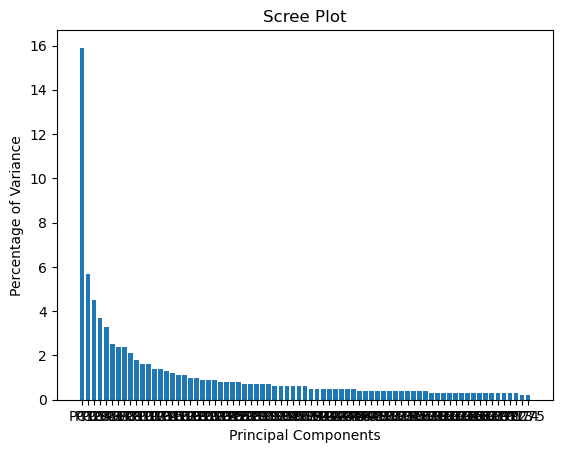

In [25]:
b_cartoon
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.savefig("CartoonPCALongerData.png") 
plt.show()

In [26]:
my_df = pd.DataFrame(b_cartoon)
my_df.to_csv('pca_cartoonnewTpoints_.csv',header = False, index= False)

In [2]:
file_path = 'im_newT_texturearray_.csv'
chunk_size = 100

df_list = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size, header = None):
    df_list.append(chunk)

df2 = pd.concat(df_list)

In [3]:
my_data_forPCA2 =df2

In [4]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA2)
scaled_landDiff.shape

(450, 168100)

In [5]:
my_data_forPCA = []

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=350)#era 14
pca.fit_transform(scaled_landDiff)
b_texture = pca.fit_transform(scaled_landDiff)
b_texture.shape # 

(450, 350)

In [18]:
print(sum(pca.explained_variance_ratio_))

0.9136942471654089


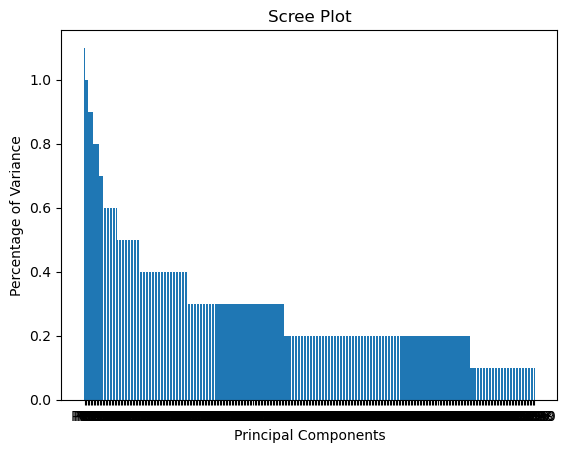

In [15]:
b_texture
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.savefig("TexturePCALongerData.png") 
plt.show()

In [20]:
my_df = pd.DataFrame(b_texture)
my_df.to_csv('pca_texturenewTpoints_.csv',header = False, index= False)

In [22]:
cartoon, texture = cartoonTexture_grey(img, 0.7, 50, 0.35, 0.35, 1.0, 0)

cartoon, img, texture

NameError: name 'ProximalG' is not defined

In [23]:
Hori = np.concatenate((cartoon, texture), axis=1) 
cv2.imshow('Cartoon Texture', Hori) 
cv2.waitKey(0) 
cv2.destroyAllWindows()  

cv2.imwrite("ejemplotexcartoondescom07w0.png", Hori)

True

In [ ]:
To counter this dependence, for each face image we di-
vide each element of the u component by the mean value of
u of that ima

In [45]:
result = (cartoon_vector == a).all()
result

True